# Basic Statistics

## Set Up

### Imports

In [1]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
from pathlib import Path
from pyprocessmacro import Process

import numpy as np
import pyperclip
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
from IPython.display import Markdown, HTML, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict

from reload_recursive import reload_recursive
import sys
import os
from my_python_utils import smart_title

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace


#### Reload modules

In [2]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

from utils import zscore
from my_namespace import presentation_cols, colors

### Load Data

#### Clinical and Volumes

In [3]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/0-Basic_statistics"
)
if not fig_path.exists():
    os.makedirs(fig_path)

data = utils.load_data("/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv")


MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"

p = "<p style='font-family: Mononoki Nerd Font Mono;line-height: 1.3;font-size: 14px;'>"

## Analysis

### Demographic and Clinical Data

### MRI Measures

In [4]:
model_data = data[MS_patients]

vars = ["WBV", "WMV", "GMV", "WTV"]
max_width = max(len(outcome) for outcome in vars)
display_text = ""
display_text += f"{p}<u>MRI Volumes:</u></p>"
display_volumes = [
    f"{var:<{max_width + 1}}: {model_data[var].mean():0.2f} ± {model_data[var].std():0.2f}"
    for var in vars
]
display_text += f"{p}{'<br>'.join(display_volumes)}</p>"
display(HTML(display_text))

In [14]:
mri_volumes = {
    "brain": "WBV (mm3)",
    "white": "WMV (mm3)",
    "grey": "GMV (mm3)",
    "THALAMUS_1": "WTV (mm3)",
    "cortical_thickness": "cortical_thickness (mm)",
}
inflammation_measures = {
    "CP": "choroid plexus (mm3)",
    "t2lv": "T2LV (mm3)",
    "PRL": "PRL count",
}
csf_compartments = {
    "LV": "LV (mm3)",
    "interCSF": "interthalamic CSF (mm3)",
    "thirdV": "third ventricle (mm3)",
    "fourthV": "fourth ventricle (mm3)",
    "periCSF": "subarachnoid CSF (mm3)",
}

csf_compartments | mri_volumes | inflammation_measures

{'LV': 'LV (mm3)',
 'interCSF': 'interthalamic CSF (mm3)',
 'thirdV': 'third ventricle (mm3)',
 'fourthV': 'fourth ventricle (mm3)',
 'periCSF': 'subarachnoid CSF (mm3)',
 'brain': 'WBV (mm3)',
 'white': 'WMV (mm3)',
 'grey': 'GMV (mm3)',
 'THALAMUS_1': 'WTV (mm3)',
 'cortical_thickness': 'cortical_thickness (mm)',
 'CP': 'choroid plexus (mm3)',
 't2lv': 'T2LV (mm3)',
 'PRL': 'PRL count'}

In [15]:
mri_volumes = {
    "brain": "whole brain volume",
    "white": "white matter volume",
    "grey": "grey matter volume",
    "THALAMUS_1": "whole thalamus volume",
    "cortical_thickness": "cortical_thickness (mm)",
}
inflammation_measures = {
    "CP": "choroid plexus (mm3)",
    "T2LV": "T2LV (mm3)",
    "PRL": "PRL count",
}
csf_compartments = {
    "LV": "lateral ventricles",
    "interCSF": "interthalamic CSF",
    "thirdV": "third ventricle",
    "fourthV": "fourth ventricle",
    "periCSF": "subarachnoid CSF",
    "CCR2": "CCR"
}
max_width = max(
    len(var_disp)
    for var_disp in (csf_compartments | mri_volumes | inflammation_measures).values()
)

# * MRI Volumes
display_volumes = [
    f"{var_disp:<{max_width + 1}}: {model_data[var].mean():0.2f} ± {model_data[var].std():0.2f}"
    for var, var_disp in mri_volumes.items()
]
print("MRI Volumes (mm3):\n-----------------------------------------------")
print("\n".join(display_volumes))

# * Measures of Inflammation
display_volumes = [
    f"{var_disp:<{max_width + 1}}: {model_data[var].mean():0.2f} ± {model_data[var].std():0.2f}"
    for var, var_disp in inflammation_measures.items()
]
print("\nMeasures of Inflammation:\n-----------------------------------------------")
print("\n".join(display_volumes))

# * CSF Compartments
display_volumes = [
    f"{var_disp:<{max_width + 1}}: {model_data[var].mean():0.2f} ± {model_data[var].std():0.2f}"
    for var, var_disp in csf_compartments.items()
]
print("\nCSF Compartments (mm3):\n-----------------------------------------------")
print("\n".join(display_volumes))

MRI Volumes (mm3):
-----------------------------------------------
whole brain volume      : 1041323.51 ± 102997.33
white matter volume     : 484966.16 ± 54254.00
grey matter volume      : 556357.35 ± 53965.54
whole thalamus volume   : 8956.19 ± 1642.31
cortical_thickness (mm) : 2.28 ± 0.13

Measures of Inflammation:
-----------------------------------------------
choroid plexus (mm3)    : 1718.20 ± 511.13
T2LV (mm3)              : 7748.56 ± 10695.12
PRL count               : 0.89 ± 1.79

CSF Compartments (mm3):
-----------------------------------------------
lateral ventricles      : 19492.70 ± 14859.00
interthalamic CSF       : 964.45 ± 348.45
third ventricle         : 955.76 ± 483.74
fourth ventricle        : 1749.45 ± 512.52
subarachnoid CSF        : 345018.14 ± 34930.85
CCR                     : 0.06 ± 0.04


In [6]:
lesion_volumes = {
    "T2LV": "total T2LV",
    "juxcort_T2LV": "juxtacortical T2LV",
    "periV_T2LV": "periventricular T2LV",
    "subcort_T2LV": "subcortical T2LV",
    "infraT_T2LV": "infratentorial T2LV"
}

max_width = max(
    len(var_disp)
    for var_disp in (lesion_volumes).values()
)

display_volumes = [
    f"{var_disp:<{max_width + 1}}: {model_data[var].mean():0.2f} ± {model_data[var].std():0.2f}"
    for var, var_disp in lesion_volumes.items()
]
print("Lesion Volumes (mm3):\n-----------------------------------------------")
print("\n".join(display_volumes))


Lesion Volumes (mm3):
-----------------------------------------------
total T2LV           : 7748.56 ± 10695.12
juxtacortical T2LV   : 1540.48 ± 2437.15
periventricular T2LV : 5618.05 ± 9514.87
subcortical T2LV     : 482.48 ± 1234.86
infratentorial T2LV  : 114.20 ± 265.07


(array([352.,  72.,  22.,  13.,   6.,   0.,   1.,   1.,   0.,   1.]),
 array([9.21597683e+00, 1.02102068e+04, 2.04111977e+04, 3.06121885e+04,
        4.08131793e+04, 5.10141702e+04, 6.12151610e+04, 7.14161518e+04,
        8.16171427e+04, 9.18181335e+04, 1.02019124e+05]),
 <BarContainer object of 10 artists>)

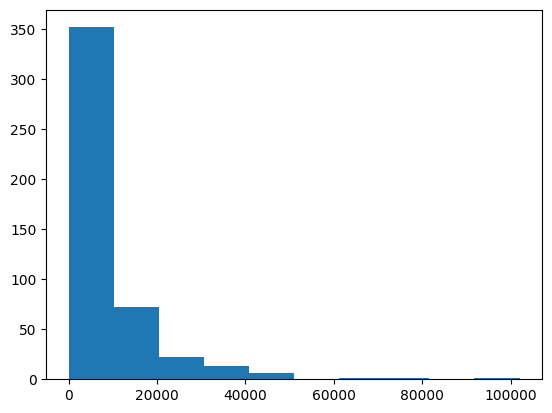

In [7]:
plt.hist(model_data['T2LV'])

In [8]:
test_data = data[MS_patients]

for var in ["brain", "white", "grey", "tiv"]:
    test_data[var] = test_data[var] / 1000

for var in ["brain", "white", "grey"]:
    test_data[f"{var}_fix"] = test_data[var] / test_data["vscaling"]


cols = ["brain", "cat12_brain", "white", "cat12_white", "grey", "cat12_grey"]
max_width = max(len(outcome) for outcome in cols)


vars = ("brain", "cat12_brain", "WBV")
for vars in [
    ("brain", "cat12_brain", "WBV"),
    ("white", "cat12_wm", "WMV"),
    ("grey", "cat12_gm", "GMV"),
    ("brain_fix", "cat12_brain", "WBV"),
    ("white_fix", "cat12_wm", "WMV"),
    ("grey_fix", "cat12_gm", "GMV"),
    ("tiv", "cat12_tiv", "TIV"),
]:
    print(f"{vars[2]}\n-----------")
    print(
        f"{vars[0]:<{max_width + 1}}: {test_data[vars[0]].mean():0.2f} ± {test_data[vars[0]].std():0.2f}"
    )
    print(
        f"{vars[1]:<{max_width + 1}}: {test_data[vars[1]].mean():0.2f} ± {test_data[vars[1]].std():0.2f}"
    )

    tmp_data = test_data[list(vars[:2])].dropna()
    slope, intercept, r, p, se = stats.linregress(tmp_data[vars[0]], tmp_data[vars[1]])
    pearsonr = stats.pearsonr(tmp_data[vars[0]], tmp_data[vars[1]])
    print(
        f"{'compare':<{max_width + 1}}: ρ={pearsonr.statistic:0.2f}, p={pearsonr.pvalue:0.2}, R2={r**2:0.2f}"
    )
    print("\n")

WBV
-----------
brain       : 1406.87 ± 81.82
cat12_brain : 1097.16 ± 119.01
compare     : ρ=0.41, p=1.3e-20, R2=0.17


WMV
-----------
white       : 654.42 ± 38.82
cat12_wm    : 612.50 ± 64.42
compare     : ρ=0.35, p=7.1e-15, R2=0.12


GMV
-----------
grey        : 752.45 ± 54.41
cat12_gm    : 484.66 ± 61.96
compare     : ρ=0.14, p=0.0022, R2=0.02


WBV
-----------
brain_fix   : 1041.32 ± 103.00
cat12_brain : 1097.16 ± 119.01
compare     : ρ=0.96, p=3.6e-253, R2=0.92


WMV
-----------
white_fix   : 484.97 ± 54.25
cat12_wm    : 612.50 ± 64.42
compare     : ρ=0.74, p=2.1e-83, R2=0.55


GMV
-----------
grey_fix    : 556.36 ± 53.97
cat12_gm    : 484.66 ± 61.96
compare     : ρ=0.84, p=2.9e-123, R2=0.70


TIV
-----------
tiv         : 1493.67 ± 128.33
cat12_tiv   : 1410.22 ± 137.61
compare     : ρ=0.95, p=1.9e-238, R2=0.90




In [ ]:
test_data = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/Clinical_Data_All_updated.csv"
)

slope, intercept, r, p, se = stats.linregress(
    test_data["brain"], test_data["cat12_brain"]
)
pearsonr = stats.pearsonr(test_data["brain"], test_data["cat12_brain"])
print(f"WBV: ρ={pearsonr.statistic:0.2f}, R2={r**2:0.2f}, p={pearsonr.pvalue:0.2}")

slope, intercept, r, p, se = stats.linregress(test_data["white"], test_data["cat12_wm"])
pearsonr = stats.pearsonr(test_data["white"], test_data["cat12_wm"])
print(f"WMV: ρ={pearsonr.statistic:0.2f}, R2={r**2:0.2f}, p={pearsonr.pvalue:0.2}")

slope, intercept, r, p, se = stats.linregress(test_data["grey"], test_data["cat12_gm"])
pearsonr = stats.pearsonr(test_data["grey"], test_data["cat12_gm"])
print(f"GMV: ρ={pearsonr.statistic:0.2f}, R2={r**2:0.2f}, p={pearsonr.pvalue:0.2}")

WBV: ρ=0.40, R2=0.16, p=2.9e-23
WMV: ρ=0.36, R2=0.13, p=1.4e-18
GMV: ρ=0.11, R2=0.01, p=0.0084


## Assumption Checks

### Functions

In [4]:
raw_ms_data = data[MS_patients]

def zscore2(df, skip_vars=None):
    """Z-score numeric columns, preserving correlation structure.
    
    WARNING: This drops rows with ANY missing values in numeric columns
    to maintain proper covariance structure.
    """
    if skip_vars is None:
        skip_vars = []
    
    df_z = df.copy()
    numeric_cols = df_z.select_dtypes(include="number").columns
    numeric_cols = numeric_cols[~numeric_cols.isin(skip_vars)]
    
    # Drop rows with any NaN in numeric columns FIRST
    df_z = df_z.dropna(subset=numeric_cols)
    
    # Now z-score (no NaNs remain, so no need for nan_policy)
    df_z[numeric_cols] = (df_z[numeric_cols] - df_z[numeric_cols].mean()) / df_z[numeric_cols].std()
    
    return df_z


def check_vif(raw_data, vars):
    raw_data = raw_data[vars]
    data = zscore2(raw_data)
    X = data[vars]
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.set_index("Variable")


def quick_print_vif(raw_data, variables, print_vars=None):
    if print_vars is None:
        print_vars = variables
    vif = check_vif(raw_data, variables)
    print_vif = vif.loc[print_vars, "VIF"]
    print(", ".join(variables))
    print("-"*40)
    display(Markdown(print_vif.to_markdown()))
    print("\n")

### VIF

In [5]:
variables = ["CP", "T2LV_log1p", "tiv", "WBV", "age", "Female"]
quick_print_vif(raw_ms_data, variables)

variables = ["CP", "T2LV_log1p", "tiv", "WTV", "CT", "age", "Female"]
quick_print_vif(raw_ms_data, variables)

CP, T2LV_log1p, tiv, WBV, age, Female
----------------------------------------


| Variable   |     VIF |
|:-----------|--------:|
| CP         | 1.80293 |
| T2LV_log1p | 1.44527 |
| tiv        | 8.83604 |
| WBV        | 9.56641 |
| age        | 1.48304 |
| Female     | 1.0763  |



CP, T2LV_log1p, tiv, WTV, CT, age, Female
----------------------------------------


| Variable   |     VIF |
|:-----------|--------:|
| CP         | 1.56571 |
| T2LV_log1p | 1.93046 |
| tiv        | 1.67956 |
| WTV        | 3.30999 |
| CT         | 2.2393  |
| age        | 1.36064 |
| Female     | 1.08016 |

#### VIF for models with WTV and additional thalamic nuclei

In [6]:
for nucleus in ["medial", "posterior", "ventral", "anterior"]:
    variables = ["CP", "WTV", nucleus, "age", "Female", "tiv",]
    quick_print_vif(raw_ms_data, variables, print_vars=["WTV", nucleus, "CP"])

CP, WTV, medial, age, Female, tiv
----------------------------------------


| Variable   |     VIF |
|:-----------|--------:|
| WTV        | 9.64538 |
| medial     | 9.22195 |
| CP         | 1.60764 |



CP, WTV, posterior, age, Female, tiv
----------------------------------------


| Variable   |      VIF |
|:-----------|---------:|
| WTV        | 11.396   |
| posterior  | 10.2198  |
| CP         |  1.56631 |



CP, WTV, ventral, age, Female, tiv
----------------------------------------


| Variable   |     VIF |
|:-----------|--------:|
| WTV        | 8.16626 |
| ventral    | 7.89023 |
| CP         | 1.67143 |



CP, WTV, anterior, age, Female, tiv
----------------------------------------


| Variable   |     VIF |
|:-----------|--------:|
| WTV        | 2.9413  |
| anterior   | 2.30892 |
| CP         | 1.55536 |

In [9]:
for nucleus in ["medial", "posterior", "ventral", "anterior"]:
    variables = ["CP", "WBV", nucleus, "age", "Female", "tiv",]
    quick_print_vif(raw_ms_data, variables, print_vars=["WBV", nucleus, "CP"])

CP, WBV, medial, age, Female, tiv
----------------------------------------


| Variable   |      VIF |
|:-----------|---------:|
| WBV        | 12.9061  |
| medial     |  2.60879 |
| CP         |  1.83232 |



CP, WBV, posterior, age, Female, tiv
----------------------------------------


| Variable   |      VIF |
|:-----------|---------:|
| WBV        | 12.3559  |
| posterior  |  2.34263 |
| CP         |  1.81788 |



CP, WBV, ventral, age, Female, tiv
----------------------------------------


| Variable   |      VIF |
|:-----------|---------:|
| WBV        | 12.5056  |
| ventral    |  2.55451 |
| CP         |  1.79737 |



CP, WBV, anterior, age, Female, tiv
----------------------------------------


| Variable   |      VIF |
|:-----------|---------:|
| WBV        | 10.0753  |
| anterior   |  1.6721  |
| CP         |  1.78628 |